In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import os
from transformers import AutoTokenizer, AutoModel

In [ ]:

# Load dataset
df = pd.read_csv("./bitcoin_articles_sentiment.csv")
df = df[["Short Description", "Accurate Sentiments"]].dropna()
df.rename(columns={"Short Description": "text", "Accurate Sentiments": "score"}, inplace=True)

     Score |   Original |      Final
-----------------------------------


<ipython-input-5-2095316147>:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


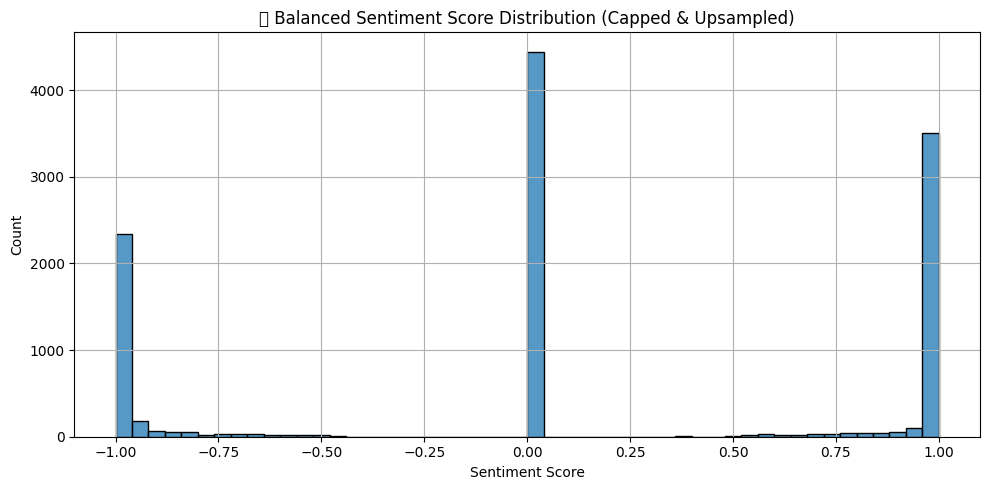

In [ ]:
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# Round sentiment scores to 2 decimals to avoid float duplicates
df["score"] = df["score"].clip(-1, 1).round(2)

# Parameters
cap = 500000
multiplicator = 1

# Track result logs
log = []

balanced = []
unique_scores = sorted(df["score"].unique())

for score in unique_scores:
    group = df[df["score"] == score]
    original_count = len(group)

    if original_count >= cap:
        sampled = resample(group, replace=False, n_samples=cap, random_state=42)
        log.append((score, original_count, cap))
    else:
        upsampled_n = min(cap, int(original_count * multiplicator))
        sampled = resample(group, replace=True, n_samples=upsampled_n, random_state=42)
        log.append((score, original_count, upsampled_n))

    balanced.append(sampled)

df_balanced = pd.concat(balanced).sample(frac=1.0, random_state=42).reset_index(drop=True)

# 🧾 Print the full log clearly
print(f"{'Score':>10} | {'Original':>10} | {'Final':>10}")
print("-" * 35)


# 📊 Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_balanced["score"], bins=50)
plt.title("✅ Balanced Sentiment Score Distribution (Capped & Upsampled)")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
3976
# Dataset class for regression
class SentimentRegressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Assume `df_balanced` exists and has columns: "text", "score"
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced["text"].tolist(), df_balanced["score"].tolist(), test_size=0.2, random_state=42
)

In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

train_dataset = SentimentRegressionDataset(train_encodings, train_labels)
val_dataset = SentimentRegressionDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.5)  # Regularization
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        prediction = self.regressor(cls_output).squeeze(-1)
        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(prediction, labels)
        return {"loss": loss, "prediction": prediction}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegressor().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Early stopping configuration
early_stop_patience = 10
best_val_loss = float("inf")
epochs_without_improvement = 0
# Directory to save the best model
save_dir = "./bert_sentiment_regression_best"
os.makedirs(save_dir, exist_ok=True)

# Loss tracking
train_losses = []
val_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs["loss"]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_postfix(batch_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs["loss"]
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.bin"))
        print("🔁 Improvement detected — model saved.")
    else:
        epochs_without_improvement += 1
        print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= early_stop_patience:
        print("\n⛔ Early stopping triggered.")
        break


Epoch 1: Train Loss = 0.3761, Val Loss = 0.1810
🔁 Improvement detected — model saved.



Epoch 2: Train Loss = 0.1516, Val Loss = 0.1289
🔁 Improvement detected — model saved.



Epoch 3: Train Loss = 0.0885, Val Loss = 0.1069
🔁 Improvement detected — model saved.



Epoch 4: Train Loss = 0.0574, Val Loss = 0.0944
🔁 Improvement detected — model saved.



Epoch 5: Train Loss = 0.0398, Val Loss = 0.0924
🔁 Improvement detected — model saved.



Epoch 6: Train Loss = 0.0320, Val Loss = 0.0925
⚠️ No improvement for 1 epoch(s).



Epoch 7: Train Loss = 0.0258, Val Loss = 0.0969
⚠️ No improvement for 2 epoch(s).



Epoch 8: Train Loss = 0.0209, Val Loss = 0.0928
⚠️ No improvement for 3 epoch(s).



Epoch 9: Train Loss = 0.0180, Val Loss = 0.0887
🔁 Improvement detected — model saved.



Epoch 10: Train Loss = 0.0145, Val Loss = 0.0895
⚠️ No improvement for 1 epoch(s).



Epoch 11: Train Loss = 0.0145, Val Loss = 0.0910
⚠️ No improvement for 2 epoch(s).



Epoch 12: Train Loss = 0.0132, Val Loss = 0.0899
⚠️ No improvement for 3 epoch(s).



Epoch 13: Train Loss = 0.0140, Val Loss = 0.0931
⚠️ No improvement for 4 epoch(s).



Epoch 14: Train Loss = 0.0155, Val Loss = 0.0942
⚠️ No improvement for 5 epoch(s).



Epoch 15: Train Loss = 0.0115, Val Loss = 0.0897
⚠️ No improvement for 6 epoch(s).



Epoch 16: Train Loss = 0.0098, Val Loss = 0.0929
⚠️ No improvement for 7 epoch(s).



Epoch 17: Train Loss = 0.0100, Val Loss = 0.0898
⚠️ No improvement for 8 epoch(s).



Epoch 18: Train Loss = 0.0097, Val Loss = 0.0909
⚠️ No improvement for 9 epoch(s).



Epoch 19: Train Loss = 0.0076, Val Loss = 0.0906
⚠️ No improvement for 10 epoch(s).

⛔ Early stopping triggered.


In [ ]:
# Evaluation
model.eval()
true_vals, pred_vals = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = outputs["prediction"]
        pred_vals.extend(preds.cpu().numpy())
        true_vals.extend(batch['labels'].cpu().numpy())

# Metrics
mse = mean_squared_error(true_vals, pred_vals)
r2 = r2_score(true_vals, pred_vals)

print(f"\nMSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Save model and tokenizer
save_dir = "./bert_sentiment_regression_base"
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
tokenizer.save_pretrained(save_dir)

print(f"\n✅ Model and tokenizer saved to: {save_dir}")



MSE: 0.0890
R²: 0.8404

✅ Model and tokenizer saved to: ./bert_sentiment_regression_base


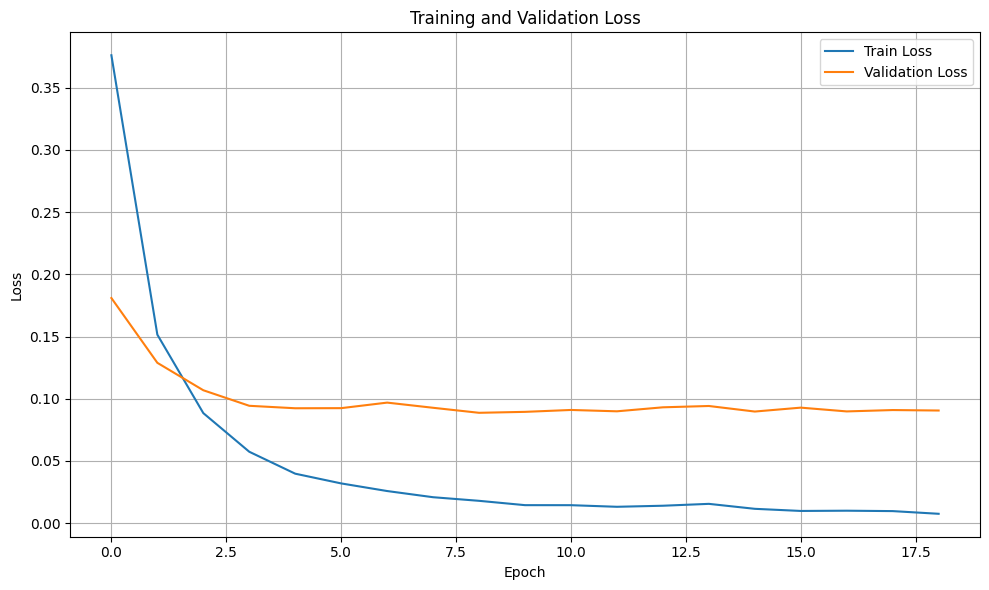

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
##%%
import shutil


print(f"\n✅ Model and tokenizer saved to: {save_dir}")

# Zip the directory
zip_path = shutil.make_archive(save_dir, 'zip', save_dir)
print(f"📦 Zipped model saved to: {zip_path}")



✅ Model and tokenizer saved to: ./bert_sentiment_regression_base_1
📦 Zipped model saved to: /content/bert_sentiment_regression_base_1.zip


In [ ]:
import h5py
import pandas as pd

h5_path = "./test_dataset.h5"

# Load the datasets
with h5py.File(h5_path, "r") as f:
    content = [text.decode("utf-8") for text in f["content"][:]]
    note = f["note"][:]

# Create a DataFrame in the same format as expected
df_test = pd.DataFrame({
    "text": content,
    "score": note
})
df_test.dropna(inplace=True)
df_test["score"] = df_test["score"].clip(-1, 1)

print(df_test.head())

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './test_dataset.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Load custom test dataset ===
# df_test should be already defined from your HDF5 extraction
# Make sure it has "text" and "score" columns

# === Tokenizer & Encodings ===
MODEL_DIR = "./bert_sentiment_regression_base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
encodings = tokenizer(df_test["text"].tolist(), truncation=True, padding=True, max_length=256)

# === Dataset class ===
class SentimentRegressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# === DataLoader ===
test_dataset = SentimentRegressionDataset(encodings, df_test["score"].tolist())
test_loader = DataLoader(test_dataset, batch_size=32)

# === Model class ===
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_DIR)
        self.dropout = nn.Dropout(0.5)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        prediction = torch.tanh(self.regressor(cls_output)).squeeze(-1)
        loss = nn.MSELoss()(prediction, labels) if labels is not None else None
        return {"loss": loss, "prediction": prediction}

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegressor().to(device)
model.load_state_dict(torch.load(f"{MODEL_DIR}/pytorch_model.bin", map_location=device))
model.eval()

# === Inference ===
true_vals, pred_vals = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        true_vals.extend(batch["labels"].cpu().numpy())
        pred_vals.extend(outputs["prediction"].cpu().numpy())

# === Metrics ===
mse = mean_squared_error(true_vals, pred_vals)
mae = mean_absolute_error(true_vals, pred_vals)
r2 = r2_score(true_vals, pred_vals)

print(f"\n📊 MSE: {mse:.4f}")
print(f"📉 MAE: {mae:.4f}")
print(f"📈 R²: {r2:.4f}")

# === Scatter plot ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=true_vals, y=pred_vals, alpha=0.6)
plt.xlabel("True Sentiment")
plt.ylabel("Predicted Sentiment")
plt.title("Predicted vs True Sentiment")
plt.grid(True)
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
residuals = np.array(true_vals) - np.array(pred_vals)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pred_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sentiment")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

true_vals_arr = np.array(true_vals)
pred_vals_arr = np.array(pred_vals)
residuals = true_vals_arr - pred_vals_arr

# Check min/max values
print("True sentiment range:", true_vals_arr.min(), "to", true_vals_arr.max())
print("Predicted sentiment range:", pred_vals_arr.min(), "to", pred_vals_arr.max())
print("Residual range:", residuals.min(), "to", residuals.max())

# Optional: find extreme cases
extreme = np.abs(residuals) > 1.5
for i in np.where(extreme)[0]:
    print(f"\nSample {i}:")
    print(f"True:      {true_vals_arr[i]}")
    print(f"Predicted: {pred_vals_arr[i]}")
    print(f"Residual:  {residuals[i]}")
